In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=f1e07ce51dab5710745b074ee2350e5b376b88edddd5b18c03888ae26653d8f1
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("SparkInColab").getOrCreate()

In [6]:
loan_dataset = spark.read.csv("loan_approval_dataset.csv", header=True, inferSchema=True)
loan_dataset.show()

+-------+----------------+-------------+-------------+------------+-----------+---------+-----------+------------------------+-----------------------+-------------------+----------------+-----------+
|loan_id|no_of_dependents|    education|self_employed|income_annum|loan_amount|loan_term|cibil_score|residential_assets_value|commercial_assets_value|luxury_assets_value|bank_asset_value|loan_status|
+-------+----------------+-------------+-------------+------------+-----------+---------+-----------+------------------------+-----------------------+-------------------+----------------+-----------+
|      1|               2|     Graduate|           No|     9600000|   29900000|       12|        778|                 2400000|               17600000|           22700000|         8000000|   Approved|
|      2|               0| Not Graduate|          Yes|     4100000|   12200000|        8|        417|                 2700000|                2200000|            8800000|         3300000|   Rejected|


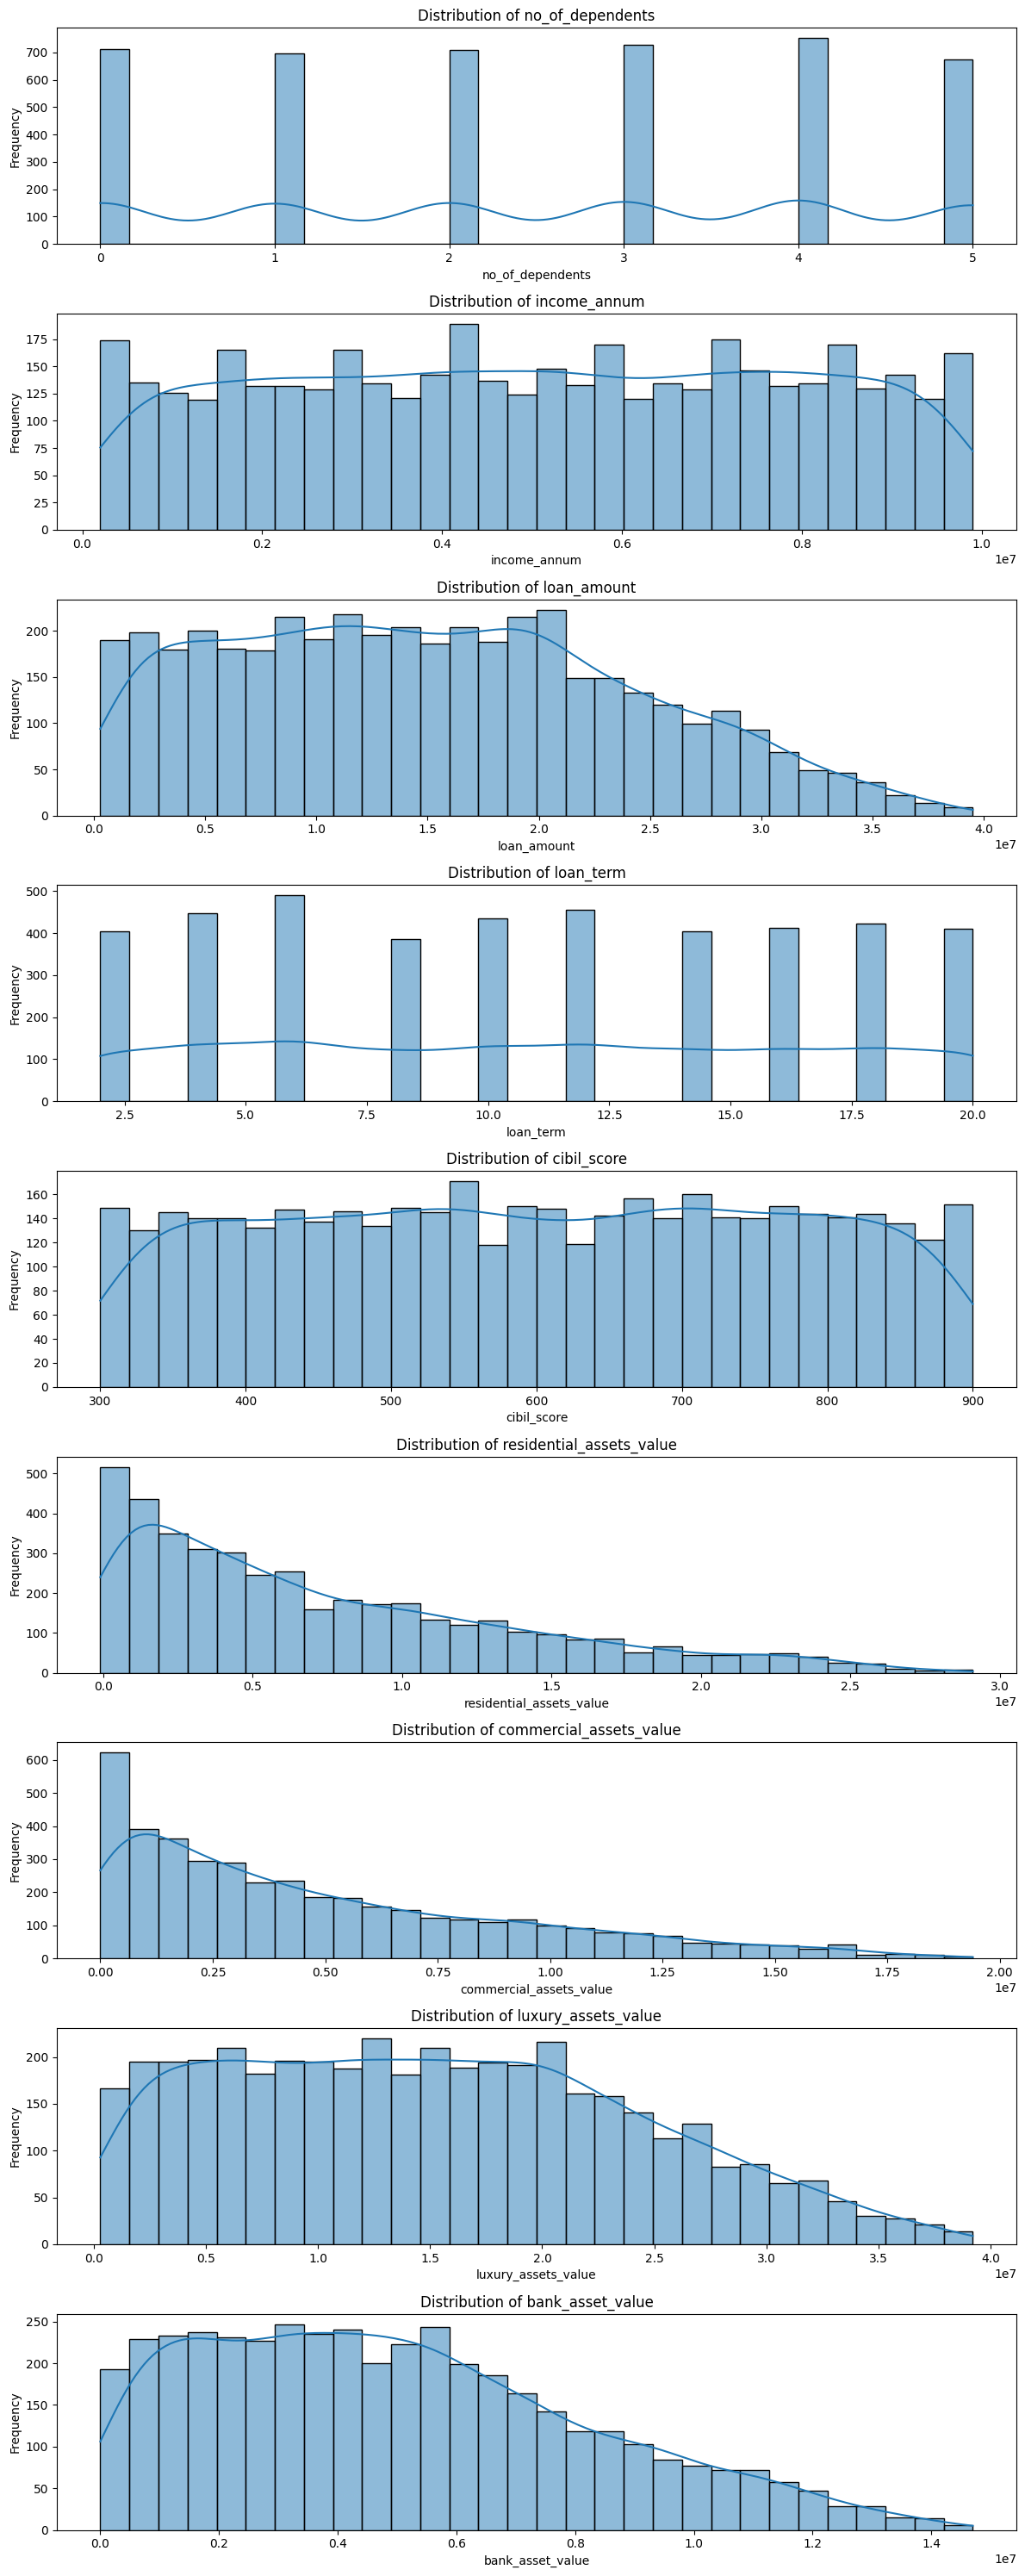

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
loan_dataset = pd.read_csv("loan_approval_dataset.csv")

# Define the numerical columns for EDA
numerical_columns = [
    'no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
    'cibil_score', 'residential_assets_value', 'commercial_assets_value',
    'luxury_assets_value', 'bank_asset_value'
]

# Plotting distributions of numerical columns
fig, axs = plt.subplots(len(numerical_columns), 1, figsize=(12, 30))

for i, col in enumerate(numerical_columns):
    sns.histplot(loan_dataset[col], ax=axs[i], kde=True, bins=30)
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

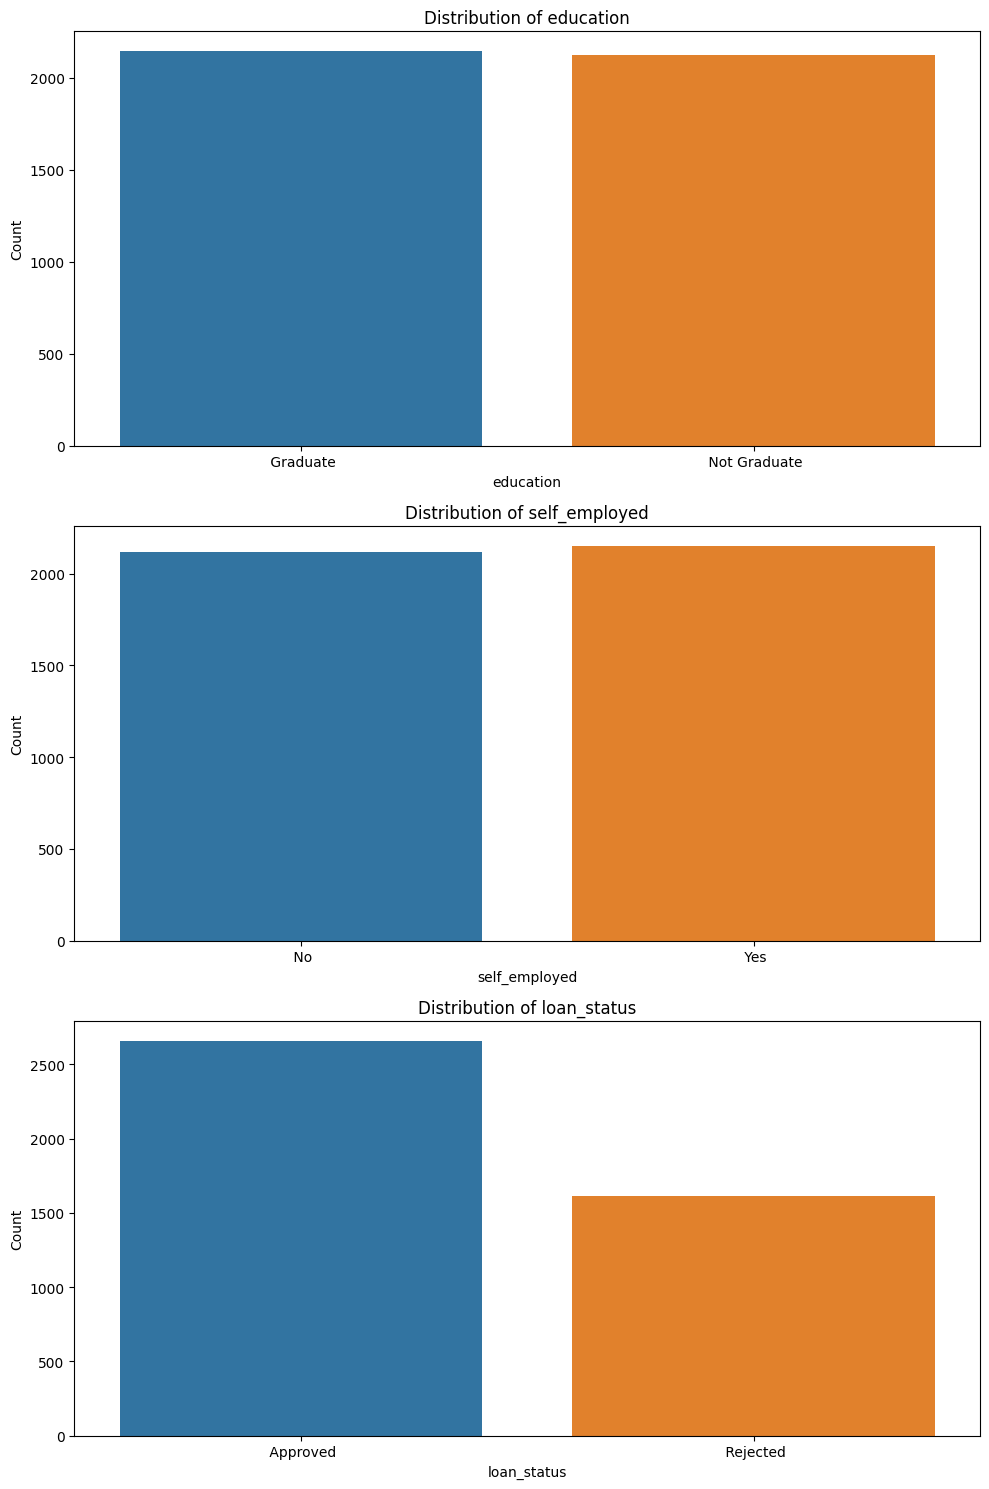

In [12]:
# EDA for Categorical Variables

categorical_columns = ['education', 'self_employed', 'loan_status']

# Plotting distributions of categorical columns
fig, axs = plt.subplots(len(categorical_columns), 1, figsize=(10, 15))

for i, col in enumerate(categorical_columns):
    sns.countplot(data=loan_dataset, x=col, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

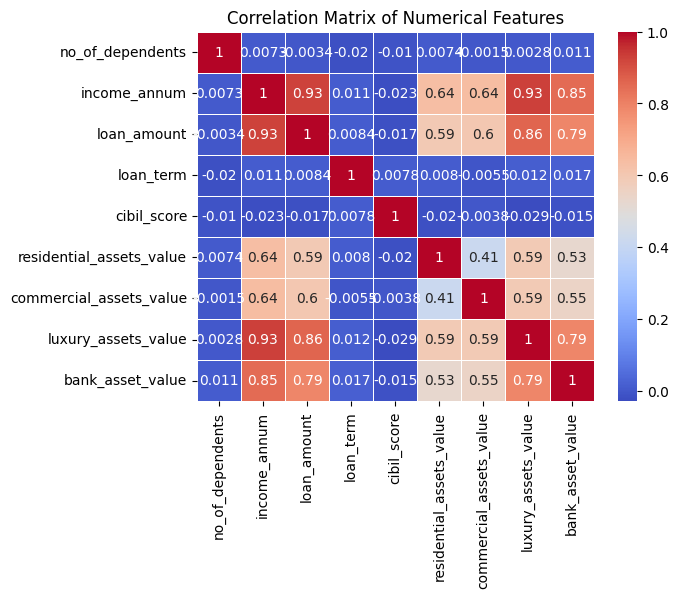

In [16]:
# Reload the dataset into a Spark DataFrame if needed
loan_dataset = spark.read.csv("loan_approval_dataset.csv", header=True, inferSchema=True)

# Now, proceed with the VectorAssembler and the rest of the operations
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assembling all numerical columns into a single vector column
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
vector_df = assembler.transform(loan_dataset)

# Compute correlation matrix
matrix = Correlation.corr(vector_df, "features").head()[0].toArray()

# Visualize the correlation matrix using seaborn's heatmap
sns.heatmap(matrix, annot=True, cmap='coolwarm', linewidths=0.5, xticklabels=numerical_columns, yticklabels=numerical_columns)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

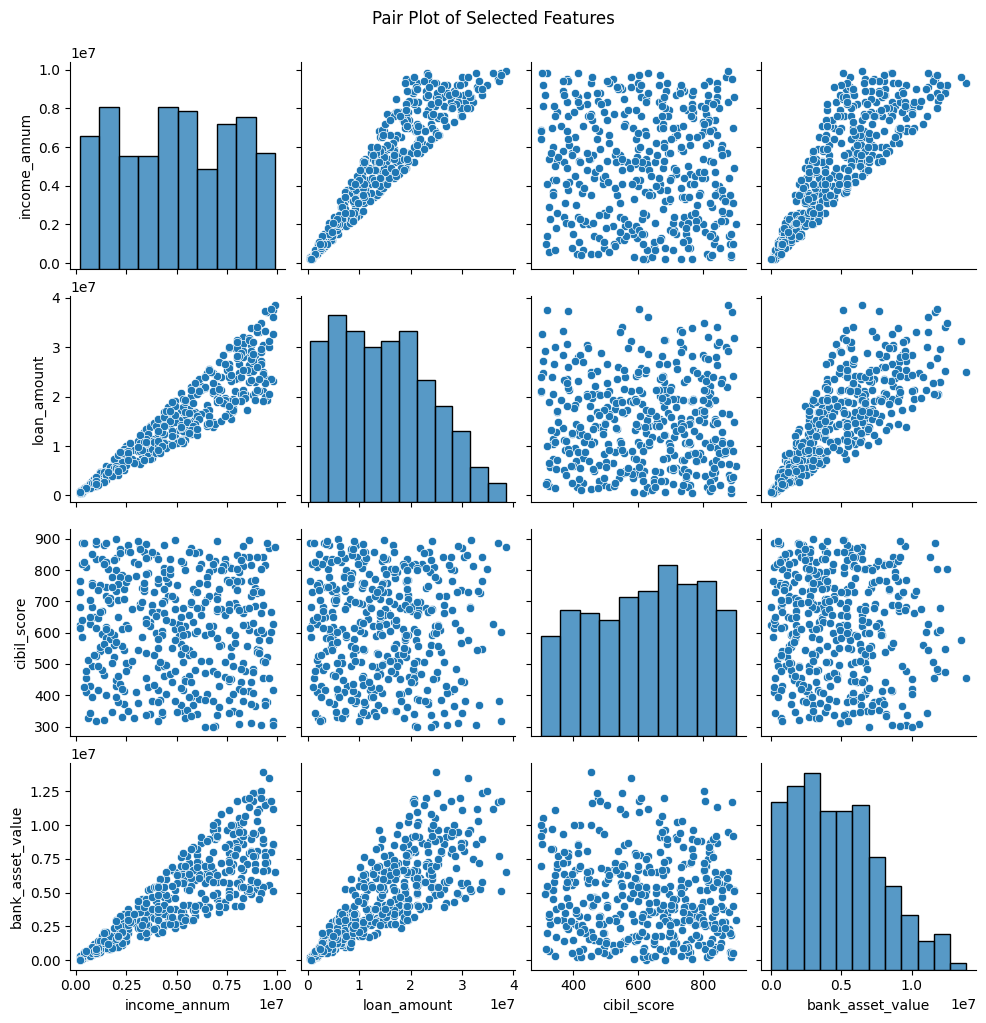

In [18]:
# Define the columns you want to include in the pair plot
selected_features = ['income_annum', 'loan_amount', 'cibil_score', 'bank_asset_value']

# Sampling a fraction of the data (e.g., 10%) and converting to pandas
sampled_data = loan_dataset.sample(fraction=0.1).toPandas()

# Using seaborn's pairplot on the sampled data
sns.pairplot(sampled_data[selected_features])
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

In [20]:
from pyspark.sql.functions import col, percentile_approx, min as spark_min, max as spark_max

# Compute necessary statistics for box plot
stats_df = (loan_dataset.groupBy("education")
           .agg(
               percentile_approx(col("income_annum"), 0.25).alias("Q1"),
               percentile_approx(col("income_annum"), 0.5).alias("Median"),
               percentile_approx(col("income_annum"), 0.75).alias("Q3"),
               spark_min(col("income_annum")).alias("Min"),
               spark_max(col("income_annum")).alias("Max")
           )
           .orderBy("education")
           .toPandas())

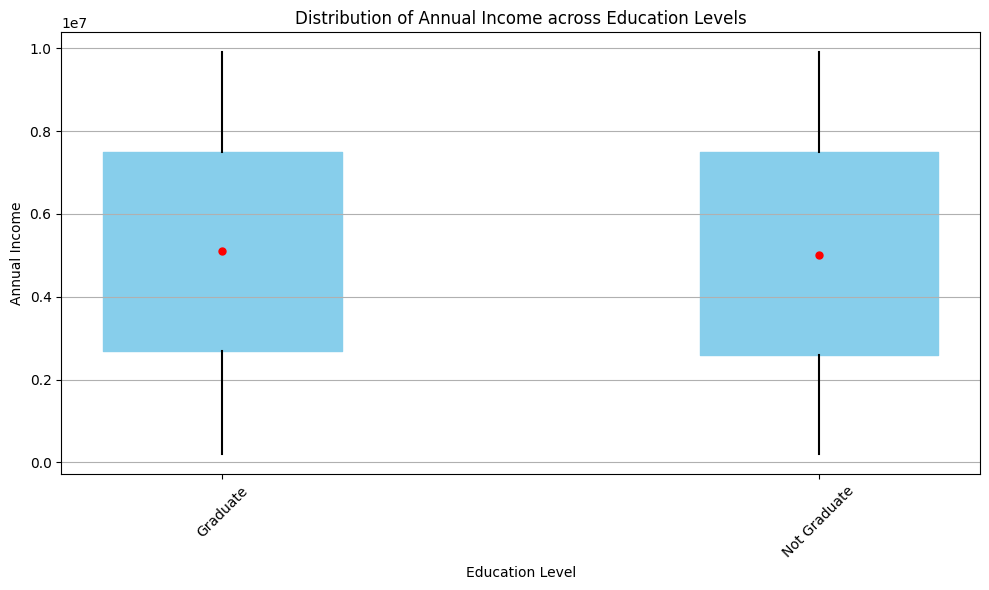

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create box plots using the computed statistics
plt.figure(figsize=(10, 6))

# For each education level, plot the box plot
for index, row in stats_df.iterrows():
    plt.plot([index, index], [row["Min"], row["Q1"]], color="black")  # lower whisker
    plt.plot([index, index], [row["Q3"], row["Max"]], color="black")  # upper whisker
    plt.plot([index], [row["Median"]], marker="o", markersize=5, color="red")  # median
    plt.fill_between([index - 0.2, index + 0.2], row["Q1"], row["Q3"], color="skyblue")  # box

plt.title('Distribution of Annual Income across Education Levels')
plt.ylabel('Annual Income')
plt.xlabel('Education Level')
plt.xticks(ticks=range(len(stats_df["education"])), labels=stats_df["education"].str.strip(), rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [22]:
# Sample a fraction of the data (e.g., 10%)
sampled_data = loan_dataset.sample(fraction=0.1).toPandas()

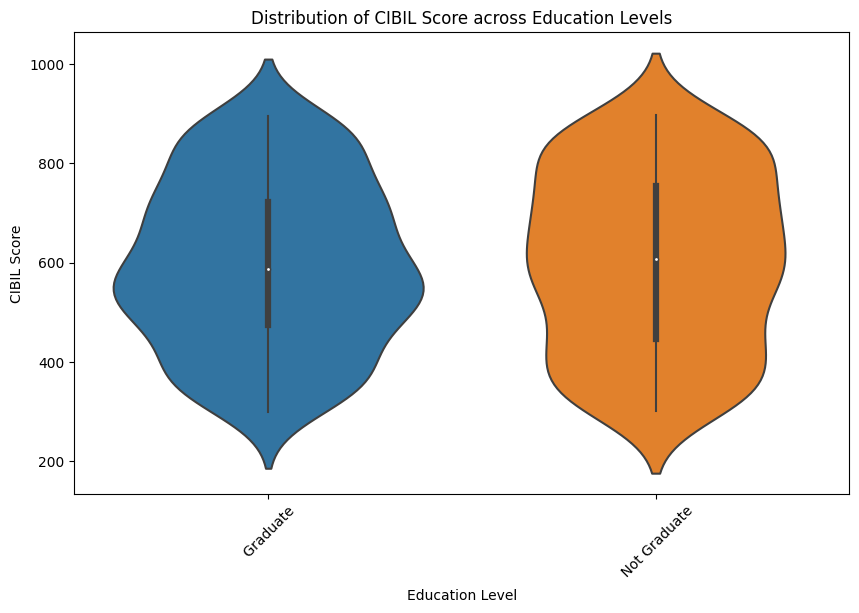

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the violin plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x='education', y='cibil_score', data=sampled_data)
plt.title('Distribution of CIBIL Score across Education Levels')
plt.ylabel('CIBIL Score')
plt.xlabel('Education Level')
plt.xticks(rotation=45)
plt.show()

In [24]:
# Sample a fraction of the data (e.g., 10%)
sampled_data = loan_dataset.sample(fraction=0.1).toPandas()

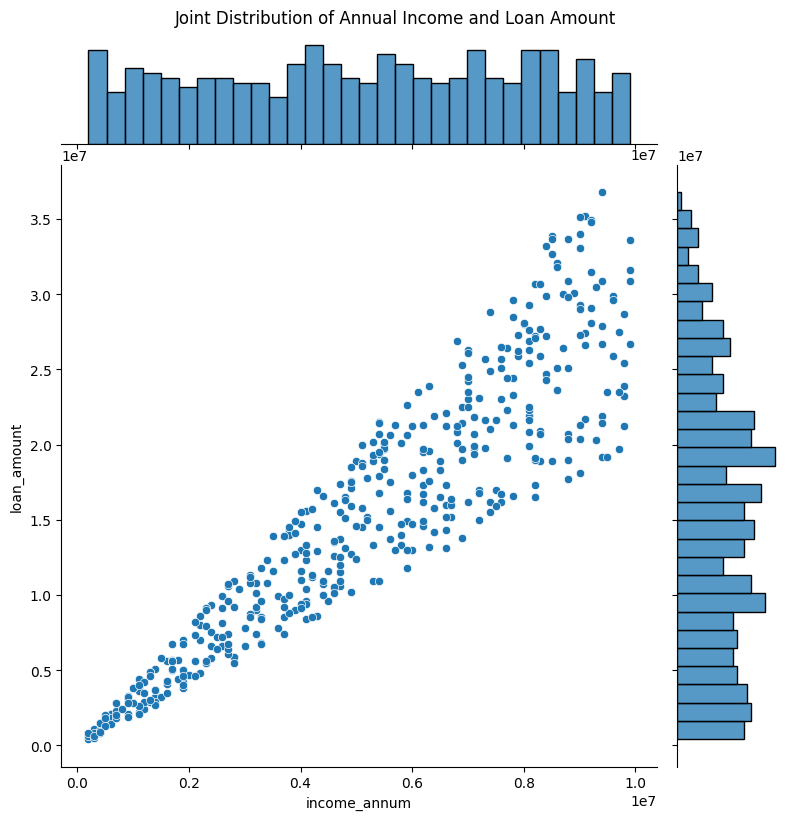

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the joint plot using seaborn
sns.jointplot(x='income_annum', y='loan_amount', data=sampled_data, kind='scatter', height=8, marginal_kws=dict(bins=30))
plt.suptitle('Joint Distribution of Annual Income and Loan Amount', y=1.02)
plt.show()

In [7]:
from pyspark.sql.functions import col, count, when

missing_values = loan_dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in loan_dataset.columns])

In [9]:
from pyspark.ml.feature import StringIndexer

categorical_columns_for_encoding = ['education', 'self_employed', 'loan_status']
indexers = []
for col in categorical_columns_for_encoding:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_indexed")
    loan_dataset = indexer.fit(loan_dataset).transform(loan_dataset)
    indexers.append(indexer)
    loan_dataset = loan_dataset.drop(col)
    loan_dataset = loan_dataset.withColumnRenamed(col+"_indexed", col)

In [10]:
train, test = loan_dataset.randomSplit([0.8, 0.2], seed=42)

X_train = train.drop('loan_status')
y_train = train.select('loan_status')

X_test = test.drop('loan_status')
y_test = test.select('loan_status')

In [11]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# First, assemble the features into a single vector column
assembler = VectorAssembler(inputCols=X_train.columns, outputCol="features")
X_train = assembler.transform(X_train)
X_test = assembler.transform(X_test)

# Now, scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(X_train)

X_train_scaled = scaler_model.transform(X_train).select("scaled_features")
X_test_scaled = scaler_model.transform(X_test).select("scaled_features")

In [12]:
train_count, feature_count = X_train_scaled.count(), len(X_train_scaled.columns)
test_count = X_test_scaled.count()

In [15]:
from pyspark.sql.functions import col
# List of feature columns
feature_columns = [col_name for col_name in train.columns if col_name not in ['loan_id', 'loan_status']]

# Assembling the features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train).select("features", col("loan_status").alias("label"))

In [17]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize the models
lr = LogisticRegression(maxIter=1000)
rf = RandomForestClassifier(seed=42)
gbt = GBTClassifier(seed=42)

models = [lr, rf, gbt]
model_names = ["Logistic Regression", "Random Forest", "Gradient Boosting"]
cv_scores = []

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

for model in models:
    # Empty parameter grid for simplicity
    paramGrid = ParamGridBuilder().build()

    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=5)

    cvModel = crossval.fit(train_data)
    avg_accuracy = sum(cvModel.avgMetrics) / len(cvModel.avgMetrics)
    cv_scores.append(avg_accuracy)


In [19]:
from pyspark.sql import Row

rows = [Row(Model=name, CVAccuracy=float(score)) for name, score in zip(model_names, cv_scores)]
model_performance = spark.createDataFrame(rows)

model_performance.show()

+-------------------+------------------+
|              Model|        CVAccuracy|
+-------------------+------------------+
|Logistic Regression|0.9146702869842809|
|      Random Forest|0.9525564621704113|
|  Gradient Boosting|0.9675957550779127|
+-------------------+------------------+



In [21]:
# Assuming you've already initialized the GBT model as:
gbt = GBTClassifier(seed=42)

# Train the model
gbt_model = gbt.fit(train_data)

# Then you can extract feature importances:
feature_importance = gbt_model.featureImportances.toArray()

In [22]:
import numpy as np

sorted_idx = np.argsort(feature_importance)

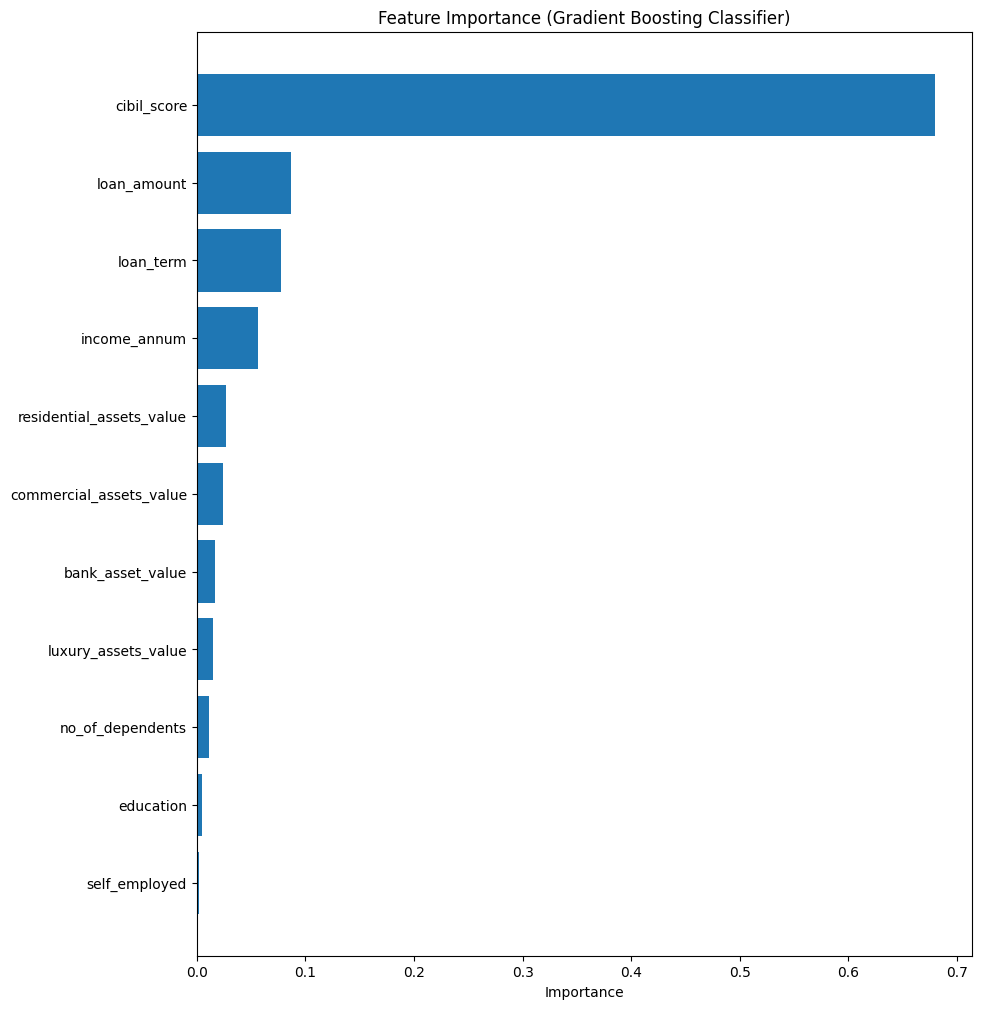

In [23]:
import matplotlib.pyplot as plt

# Extract the feature names from the VectorAssembler
feature_names = assembler.getInputCols()

plt.figure(figsize=(10, 12))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance (Gradient Boosting Classifier)')
plt.show()

In [28]:
from pyspark.ml.feature import Bucketizer, StringIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Binning the cibil_score
splits = [float('-inf'), 650, 750, 900, float('inf')]
bucketizer = Bucketizer(splits=splits, inputCol="cibil_score", outputCol="cibil_score_bin")
loan_dataset = bucketizer.transform(loan_dataset)

# 2. Encoding the binned categories
indexer = StringIndexer(inputCol="cibil_score_bin", outputCol="cibil_score_bin_indexed")
loan_dataset = indexer.fit(loan_dataset).transform(loan_dataset)

# 3. Preparing the dataset
loan_dataset = loan_dataset.drop("cibil_score")
feature_columns = [col_name for col_name in loan_dataset.columns if col_name not in ['loan_id', 'loan_status']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
loan_dataset = assembler.transform(loan_dataset)

# 4. Splitting the dataset
(train_data, test_data) = loan_dataset.randomSplit([0.8, 0.2], seed=42)

# 5. Scaling the data - In Spark, this would typically involve a StandardScaler step, but we'll skip for simplicity.

# 6. Train the GBT Classifier
gbt = GBTClassifier(labelCol="loan_status", featuresCol="features", seed=42)
gbt_model = gbt.fit(train_data)

# 7. Predict and evaluate
predictions = gbt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="loan_status", predictionCol="prediction", metricName="accuracy")
accuracy_binned = evaluator.evaluate(predictions)

# Display results
print("Accuracy with Binned Data:", accuracy_binned)

Accuracy with Binned Data: 0.8505603985056039
